### Imports

In [24]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
from biotuner.dictionaries import *
import matplotlib.pyplot as plt
import pytuning.visualizations.scales
from pytuning.visualizations.scales import consonance_matrix
import csv
import os
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Constructing euclidian rhythms from biotunings

Euclidean rhythms represent an even distribution of pulses within a specified number of steps. It is possible to convert frequency ratios into euclidian rhythms in that a ratio's numerator can be seen as the number of pulses and a ratio's denominator as the number of steps within which the pulses should be distributed. In this notebook we will see how to derive Euclidean rhythms from EEG signal by extracting spectal peaks and looking at their frequency ratios. Therefore, more consonant brain frequency ratios will lead to more aligned Euclidean polyrhythms. 

In [25]:
# Load dataset
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

# Select a single time series
data_ = data[20]
start = time.time()

# Initialize biotuner object
biotuning_harm_peaks = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5) 

# Extract spectral peaks
biotuning_harm_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 4, harm_limit = 128)
#print(biotuning_harm_peaks.all_harmonics)

stop = time.time()
print(stop-start)

# Print the extracted peaks
print('Spectral peaks :', biotuning_harm_peaks.peaks)

# Create harmonic tuning
harm_tuning = harmonic_tuning(biotuning_harm_peaks.all_harmonics)
print(harm_tuning)

Number of peaks : 3
0.006554841995239258
Spectral peaks : [ 8.5 13.  17. ]
[1.125, 1.1875, 1.25, 1.5, 1.5625, 1.65625, 1.78125, 1.875, 2.0]


### Deriving euclidian rhythms from a series of ratios

When mode = 'normal', the ratios are inverted and the numerator is taken as the number of pulses and the denominator as the number of steps (e.g. 3/2 -> 2pulses/3steps).

When mode = 'full', the ratios are inverted. The number of steps corresponds to num*denom and the numbers of pulses correspond to both the initial numerator and denominator (e.g. 3/2 -> 3pulses/6steps and 2pulses/6steps)

In [33]:
from biotuner.rhythm_construction import scale2euclid, interval_vector, euclid_string_to_referent, interval_vec_to_string

# Convert the tuning from ratios to fractions
harm_tuning_frac, _, _ = scale2frac(harm_tuning[3:10])
print('Tuning :', harm_tuning_frac)

# Derive euclidian rhythms from the harmonic tuning
euclid_patterns = scale2euclid(harm_tuning[3:10], max_denom = 16, mode = 'normal')
print('Euclid patterns :', euclid_patterns)

# Compute interval vectors
interval_vectors = [interval_vector(x) for x in euclid_patterns]
print('Interval vectors :', interval_vectors)

# Compare rhythms to referents
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_referent

Tuning : [3/2, 25/16, 53/32, 57/32, 15/8, 2]
Euclid patterns : [[1, 1, 0], [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [1, 0]]
Interval vectors : [[1, 2], [2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1], [2, 2, 1], [2, 2, 2, 1, 2, 2, 2, 1, 2], [2, 2, 2, 2, 2, 2, 2, 1], [2]]


['A common Afro-Cuban drum pattern when started on the second onset as in [101]. For example, it is the conga rhythm of the (6/8)-time Swing Tumbao. It is common in Latin American music, as for example in the Cueca, and the coros de clave. It is common in Arabic music, as for example in the Al Taer rhythm of Nubia. It is also a rhythmic pattern of the Drum Dance of the Slavey Indians of Northern Canada',
 'None',
 'When started on the second onset, it is a thirteenth century Persian rhythm by the name of Khafif-e-ramal, as well as a Rumanian folk-dance rhythm.',
 'It is a rhythm necklace used in the Central African Republic. When it is started on the second onset it is a bell pattern of the Luba people of Congo. When it is started on the fourth onset it is a rhythm played in West and Central Africa, as well as a cow-bell pattern in the Brazilian samba. When it is started on the penultimate onset it is the bell pattern of the Ngbaka-Maibo rhythms of the Central African Republic.',
 'Non

### Finding consonant euclidian rhythms from a set of frequency ratios
'consonant_euclid' function derives euclidian rhythm from a set of consonant intervals. 

First, a set of denominators is defined by finding the common denominator of each pair of ratios (e.g. 3/5 and 4/7 give 5*7=35). 

The consonance is computed on each pairs of denominators to find harmonic subdivisions. Only the euclidian rhythms from consonant denominators (steps) are returned.

The extracted rhythms are compared to a dictionary containing a large database of known rhythms and their origin and description.

The 

In [60]:
from biotuner.rhythm_construction import consonant_euclid, interval_vec_to_string

# Derive consonant euclidian rhythms from the harmonic tuning
euclid_final, cons = consonant_euclid(harm_tuning, n_steps_down = 1, limit_denom = 8, 
                                      limit_cons = 0.5, limit_denom_final = 8)
print('Euclid patterns :', euclid_final)

# Compare rhythms to referents
interval_vectors = [interval_vector(x) for x in euclid_final]
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_referent

Euclid patterns : [[1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], [1, 0, 1, 1, 0, 1, 1, 0], [1, 1, 0, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0]]


['None',
 'When started on the second onset, it is a thirteenth century Persian rhythm by the name of Khafif-e-ramal, as well as a Rumanian folk-dance rhythm.',
 'None',
 'It is the Cuban cinquillo pattern, the Malfuf rhythmic pattern of Egypt, as well as the Korean Nong Pyon drum pattern. Started on the second onset, it is a popular Middle Eastern rhythm, as well as the Timini rhythm of Senegal, the Adzogbo dance rhythm of Benin, the Spanish Tango, the Maksum of Egypt, and a 13th century Persian rhythm, the Al-saghil-alsani. When it is started on the third onset it is the Musemmen rhythm of Turkey. When it is started on the fourth onset it is the Kromanti rhythm of Surinam.',
 'None',
 'None',
 'When started on the seventh (last) onset, is a typical rhythm played on the Bendir (frame drum), and used in the accompaniment of songs of the Tuareg people of Libya.']

### Visualizing euclidean biorhythms

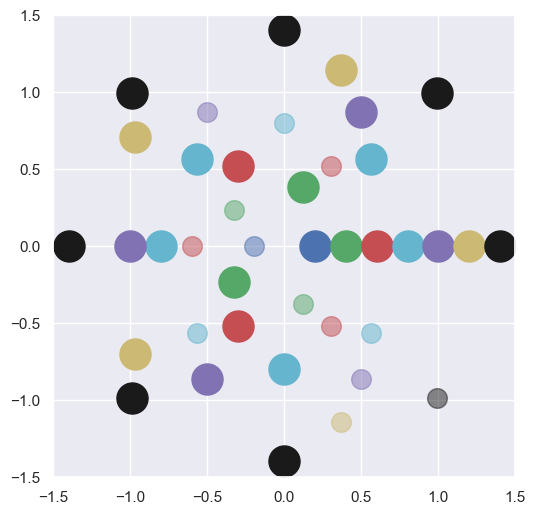

In [61]:
# variability of scales of integration for optimal brain homeostatic growth
from biotuner.vizs import visualize_rhythms
euclid_rhythms = []
for i in range(len(euclid_final)):
    pulse = euclid_final[i].count(1)
    steps = len(euclid_final[i])
    euclid_rhythms.append((pulse, steps))
visualize_rhythms(euclid_rhythms)


In [28]:
#cons_harm_tuning = sort_scale_by_consonance(harm_tuning) # sorting a tuning by consonance of intervals
#cons_harm_tuning